In [1]:
import IPython.core.display as di
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

This is a very general summary of the demodulation that was done from June 28 to July 5th. 
It was mainly tweaking differences in estimating centers and managing hanning function multiplication. 
It is found in demodulation3 and demodulation2.

Mira

In [6]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import pickle
import sys
import numpy as np
import scipy.optimize as op
from scipy.optimize import curve_fit
with open( '../../../data/raw_data/20170615_1658_2mms_90DHW_chopped.pkl' , 'rb') as f:
    d = pickle.load(f, encoding='latin1') 

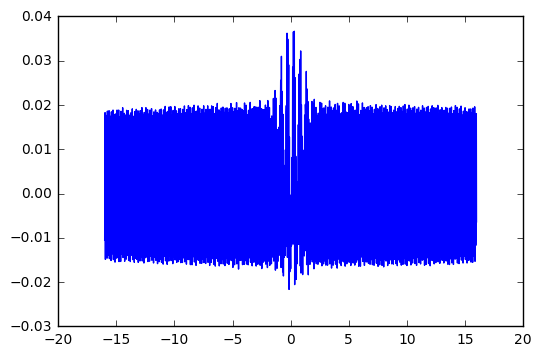

In [7]:
i = 11
Nsize = 2**i
dt=(1/(d['sample freq'])) #period
T1=dt*(Nsize) #full period
v=(d['speed'])
X = v*T1 #full distance
dx = dt*v #smallest amount of distance travelled
total_t = (d['scan time']) #how long it ran
    
total_s = (d['samples requested']) #number of samples 
startpt = ((total_s - Nsize)/2) #starting point


endpt = startpt + Nsize #ending point
startpt = int(startpt)
endpt = int(endpt)

df = 1/T1
f = df*np.arange(Nsize/2)+df/2.0
fFull = df*np.arange((Nsize/2) + 1)+df/2.0


y = (d['sig0F'])
D = y[startpt:endpt]
#D = np.flipud(D)

a = d['delay0F']/v
t = a[startpt:endpt]

pl.plot(t,D) #cut off
pl.show()

This graph above is the raw data that will be demodulated. 
Below is the graph of the spectrum, with the peak determined by the maximum y value of the spectrum. This is shown by the green line. This is what will be centered at zero.

In [14]:
def maxX(x,y):
    maxy = max(y)
    maxx = x[y.argmax()]  # Find the x value corresponding to the maximum y value
    return 300*maxx, maxy, y.argmax()

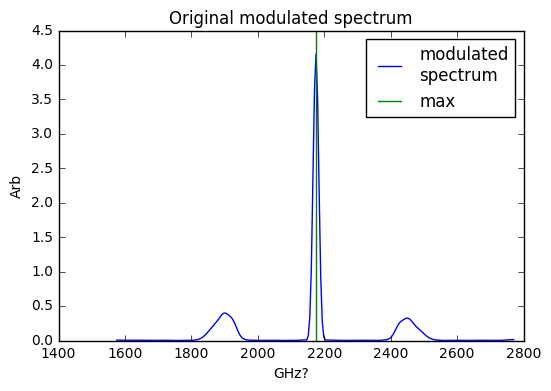

In [16]:
D = np.hanning(Nsize)*D
S = np.fft.rfft(D)
S = S[0:-1]
u = np.abs(S)
dNu = 1/(Nsize*dx)
Nu = dNu*np.arange(Nsize/2)

i1 = 8
Nsize1 = 2**i1
startpt1 = (maxX(Nu,u)[2]- (Nsize1)/2)
endpt1 = startpt1 + Nsize1 #ending point
startpt1 = int(startpt1)
endpt1 = int(endpt1)

pl.plot(300*Nu[startpt1:endpt1], u[startpt1:endpt1], label = 'modulated\nspectrum')
pl.title('Original modulated spectrum')
#pl.xlim(0,2000)
pl.xlabel('GHz?')
pl.ylabel('Arb')
pl.axvline(x = maxX(Nu,u)[0], color = 'green', label = 'max')
pl.legend()
pl.show()
fs = d['sample freq']


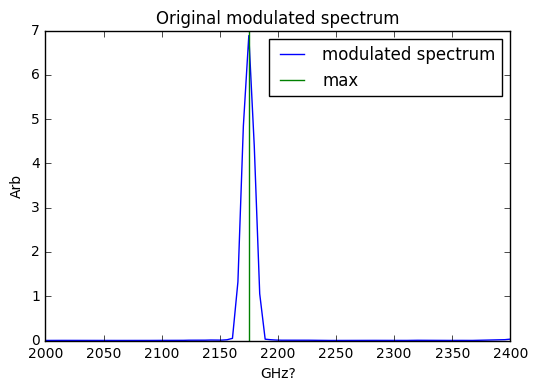

In [11]:
pl.plot(300*Nu[startpt1:endpt1], u[startpt1:endpt1], label = 'modulated\nspectrum')
pl.title('Original modulated spectrum')
pl.xlim(2000,2400)
pl.xlabel('GHz?')
pl.ylabel('Arb')
pl.axvline(x = maxX(Nu,u)[0], color = 'green', label = 'max')
pl.legend()
pl.show()
#location of the maximum on the x axis

Above is the modulated spectrum with the side lobes ignored to emphasize the imperfection of the peak due to sample frequency.

This middle peak (the carrier) is then removed. This is done so in the following way:

First the spectrum is multiplied by a hanning function, and then it is cyclically shifted so that the carrier is at zero (see page 75 of lab notebook) and rotated around zero. It is then multiplied again by a hanning function. The lobes are hence emphazized and the carrier peak removed. This spectrum is then inverse fourier transformed leading to this cyclically rotated interferogram, dmod.

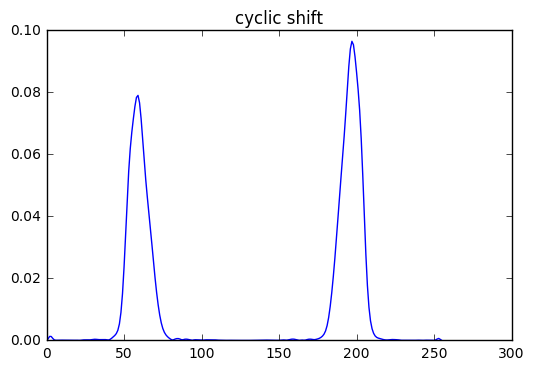

In [23]:
uNew = (np.fft.ifftshift(u[startpt1:endpt1]*np.hanning(Nsize1)))
pl.plot(uNew*np.hanning(Nsize1))
pl.title('cyclic shift')

/Users/Lab/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


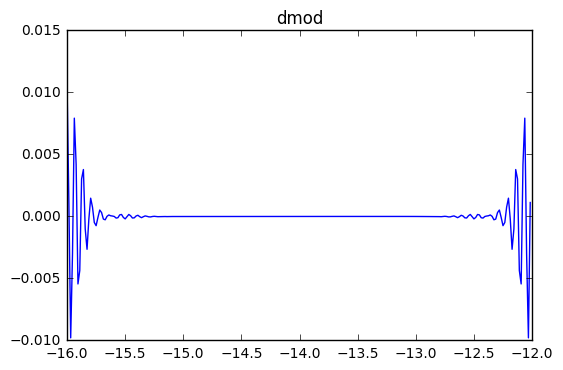

In [24]:
dmod = np.fft.ifft(uNew*np.hanning(Nsize1))
t2 = t[:-1792]
pl.plot(t2,dmod)
pl.title('dmod')

When this is cyclically again we get the demodulated spectrum shown below!

/Users/Lab/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


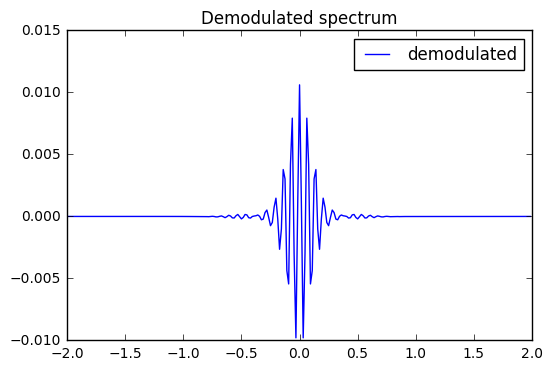

In [27]:
t3 = ([x+14 for x in t2])
pl.plot(t3,np.fft.fftshift(dmod), label = 'demodulated')
pl.legend()
pl.title('Demodulated spectrum')
pl.show() 